In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

# For reproducibility
np.random.seed(42)


In [6]:
# Environment Definition

class ResourceGatheringEnv:
    """
    A grid environment where multiple agents gather resources and return them
    to a common depot cell at (0, 0).

    Attributes:
        grid_size: Tuple (rows, cols) specifying environment size
        n_resources: Number of resource cells to place randomly
        resources_positions: Set of (r, c) positions where resources are located
        resource_collected: Boolean map indicating which resources are collected
        depot_pos: The coordinate of the depot/base, default is (0, 0)
    """

    def __init__(self, grid_size=(10, 10), n_resources=10, depot_pos=(0, 0)):
        self.grid_size = grid_size
        self.n_resources = n_resources
        self.depot_pos = depot_pos

        # Randomly place distinct resources across the grid (excluding the depot)
        available_positions = [
            (r, c)
            for r in range(self.grid_size[0])
            for c in range(self.grid_size[1])
            if (r, c) != self.depot_pos
        ]
        chosen_positions = np.random.choice(
            range(len(available_positions)), size=n_resources, replace=False
        )
        self.resource_positions = set(available_positions[i] for i in chosen_positions)

        # Track resource collection
        self.resource_collected = defaultdict(lambda: False)

    def is_valid_position(self, pos):
        """Check if a position is within the grid boundary."""
        r, c = pos
        return 0 <= r < self.grid_size[0] and 0 <= c < self.grid_size[1]

    def step(self, agent, action):
        """
        Execute one time-step for a given agent based on its action (movement).
        action: tuple (dr, dc), e.g., (1, 0) means move down one cell.
        """
        # Move the agent if the new position is valid
        new_r = agent.position[0] + action[0]
        new_c = agent.position[1] + action[1]
        if self.is_valid_position((new_r, new_c)):
            agent.position = (new_r, new_c)

        # Check if the agent is on a resource cell
        if agent.position in self.resource_positions and not self.resource_collected[agent.position]:
            agent.carrying_resource = True
            self.resource_collected[agent.position] = True

        # If the agent is at the depot and is carrying a resource, deposit it
        if agent.position == self.depot_pos and agent.carrying_resource:
            agent.carrying_resource = False
            agent.resources_collected += 1

    def all_resources_collected(self):
        """Returns True if all resources are collected."""
        return all(self.resource_collected[pos] for pos in self.resource_positions)


In [7]:
# Agent Definition
class Agent:
    """
    Basic agent that can move up/down/left/right or stay in place.
    Contains a simple interface for taking actions and storing state.
    """

    def __init__(self, agent_id, start_pos=(0, 0)):
        self.agent_id = agent_id
        self.position = start_pos
        self.carrying_resource = False
        self.resources_collected = 0

    def __repr__(self):
        return f"Agent(id={self.agent_id}, pos={self.position}, carrying={self.carrying_resource})"

# Coordinator

class Coordinator:
    """
    A simple coordinator that assigns target locations to each agent.
    It uses a greedy strategy: each agent is assigned the nearest uncollected resource.
    Once an agent collects a resource and returns it, the coordinator assigns the next resource.
    """

    def __init__(self, env, agents):
        self.env = env
        self.agents = agents
        # For each agent, store the next assigned target (resource position)
        self.assigned_targets = {agent.agent_id: None for agent in agents}

    def update_assignments(self):
        """
        Assign each agent the closest uncollected resource.
        If no uncollected resources remain, set target to depot for final return.
        """

        # Find all uncollected resources
        uncollected = [
            pos for pos in self.env.resource_positions
            if not self.env.resource_collected[pos]
        ]

        for agent in self.agents:
            # If this agent is carrying a resource, direct it to depot
            if agent.carrying_resource:
                self.assigned_targets[agent.agent_id] = self.env.depot_pos
            else:
                # If all resources are collected, send agent to depot
                if not uncollected:
                    self.assigned_targets[agent.agent_id] = self.env.depot_pos
                else:
                    # Assign the nearest resource
                    agent_pos = agent.position
                    nearest_resource = min(
                        uncollected,
                        key=lambda rpos: abs(rpos[0] - agent_pos[0]) + abs(rpos[1] - agent_pos[1])
                    )
                    self.assigned_targets[agent.agent_id] = nearest_resource

    def get_action(self, agent):
        """
        Return a simple movement action to move the agent closer to its assigned target.
        Actions are in the form (dr, dc), e.g., (1, 0) for moving down.
        """
        target = self.assigned_targets[agent.agent_id]
        if target is None:
            # No target assigned, do not move
            return (0, 0)

        # Move in the direction of the target
        agent_r, agent_c = agent.position
        target_r, target_c = target

        dr = target_r - agent_r
        dc = target_c - agent_c

        # Normalise the movement to a single step in row or column
        if dr != 0:
            dr = int(dr / abs(dr))
        if dc != 0:
            dc = int(dc / abs(dc))

        return (dr, dc)


# Simulation Manager

class SimulationManager:
    """
    Manages running the multi-agent simulation for a given number of steps or
    until all resources are collected.
    """

    def __init__(self, env, agents, coordinator):
        self.env = env
        self.agents = agents
        self.coordinator = coordinator
        self.timestep = 0

        # Data tracking
        self.history = {
            'timestep': [],
            'total_resources_collected': [],
            'agent_positions': [],
            'agent_carrying': []
        }

    def run(self, max_steps=200):
        """
        Run the simulation for up to max_steps or until all resources are collected.
        """
        while self.timestep < max_steps:
            # 1. Update coordinator assignments
            self.coordinator.update_assignments()

            # 2. Each agent acts
            for agent in self.agents:
                action = self.coordinator.get_action(agent)
                self.env.step(agent, action)

            # 3. Log data
            self.log_data()

            # Check if all resources are collected
            if self.env.all_resources_collected():
                # Keep going until all carrying agents deposit their resources, or a safety net
                if all(not a.carrying_resource for a in self.agents):
                    break

            self.timestep += 1

        print(f"Simulation finished at timestep {self.timestep} with "
              f"{self.get_total_resources_collected()} resources collected.")

    def get_total_resources_collected(self):
        return sum(agent.resources_collected for agent in self.agents)

    def log_data(self):
        self.history['timestep'].append(self.timestep)
        self.history['total_resources_collected'].append(self.get_total_resources_collected())
        self.history['agent_positions'].append([agent.position for agent in self.agents])
        self.history['agent_carrying'].append([agent.carrying_resource for agent in self.agents])

    def plot_results(self):
        """
        Plot the total resources collected over time.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(self.history['timestep'], self.history['total_resources_collected'], marker='o')
        plt.title("Total Resources Collected Over Time")
        plt.xlabel("Timestep")
        plt.ylabel("Resources Collected")
        plt.grid(True)
        plt.show()

Simulation finished at timestep 41 with 9 resources collected.


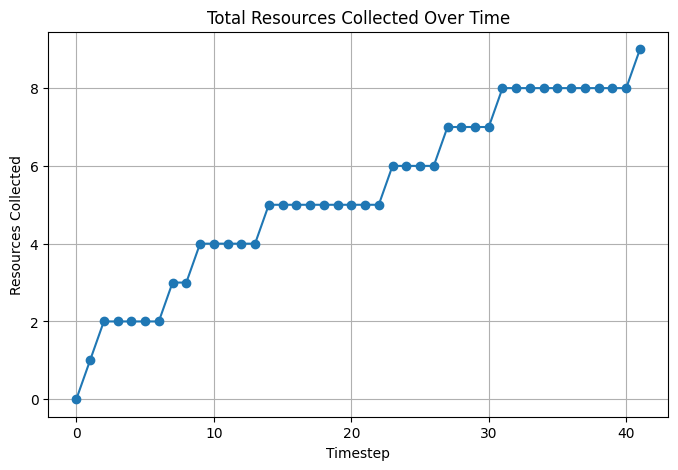

Agent 1 collected 4 resource(s).
Agent 2 collected 3 resource(s).
Agent 3 collected 2 resource(s).


In [8]:
def main_demo():
    env = ResourceGatheringEnv(grid_size=(10, 10), n_resources=12, depot_pos=(0, 0))

    agents = [
        Agent(agent_id=1, start_pos=(0, 0)),
        Agent(agent_id=2, start_pos=(0, 0)),
        Agent(agent_id=3, start_pos=(9, 9))  # one agent starting at opposite corner
    ]

    coordinator = Coordinator(env, agents)

    sim_manager = SimulationManager(env, agents, coordinator)

    sim_manager.run(max_steps=300)

    sim_manager.plot_results()

    for agent in agents:
        print(f"Agent {agent.agent_id} collected {agent.resources_collected} resource(s).")

main_demo()